# GPU-accelerated Filtered Backprojection

Using Astra.

1. Source code copied directly (not relevant to us)

In [2]:
from __future__ import division
 
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import get_writer
 
import astra
from tifffile import imsave

import sys
sys.path.append('../')
from Srayan_autoalign import srayan_autoalign

Code starts here

2. Reconstruction of our image from 2D geometry

(400, 1392, 1040)
<class 'numpy.ndarray'>


100%|███████████████████████████████████████████████████████████████████████████████| 520/520 [00:05<00:00, 103.92it/s]


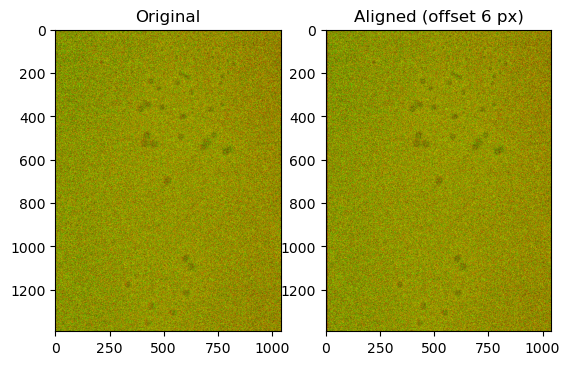

(400, 1392, 1040)

In [22]:
from skimage import io
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import gc
#del im
#del reconstruction_fbp
gc.collect()

PATH_TO_IMAGE =  'embryo_stack.tif'
PATH_TO_IMAGE = r'D:\MSci_Project\1_Data\2023-02-10 10pc 15um 3d phantom\2023-02-10 10pc 15um 3d phantom ff 400proj\1_1\1_1_MMStack_Pos0.ome.tif'
im = io.imread(PATH_TO_IMAGE)
print(im.shape)
print(type(im))
srayan_autoalign.plot_alignment(im)

# Crop image
#im = im[:,:,10:]
im.shape

In [23]:
im = srayan_autoalign.apply_offset(im)

100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 377.07it/s]


In [24]:
# Turn into sinogram
im = np.moveaxis(im, 0, -2).astype('float64')
print(im.shape)

# Preallocate Memory
reconstruction_fbp = np.zeros((im.shape[0], im.shape[2], im.shape[2]))

(1392, 400, 1040)


In [25]:
# Configuration.
#distance_source_origin = 300  # [mm]
#distance_origin_detector = 100  # [mm]
#detector_pixel_size = 1.05  # [mm]
detector_rows = im.shape[0]  # Vertical size of detector [pixels].
detector_cols = im.shape[-1]  # Horizontal size of detector [pixels].
num_of_projections = 400
angles = np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)
input_dir = 'dataset'
output_dir = 'ff_auto'
 
start = time.time()
for i in tqdm(range(im.shape[0])):
    # Copy projection images into ASTRA Toolbox.
    proj_geom = \
      astra.create_proj_geom('parallel', 1.0, detector_cols, angles)
    projections_id = astra.data2d.create('-sino', proj_geom, im[i])

    # Create reconstruction.
    vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                              detector_rows)
    reconstruction_id = astra.data2d.create('-vol', vol_geom, data=0)
    alg_cfg = astra.astra_dict('FBP_CUDA')
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data2d.get(reconstruction_id)

    # Limit and scale reconstruction.
    reconstruction[reconstruction < 0] = 0
    reconstruction /= 4000
    reconstruction = np.round(reconstruction * 65535).astype(np.uint16)

    # Save reconstruction.
    if not isdir(output_dir):
        mkdir(output_dir)
    #for i in range(detector_rows):
        #im = reconstruction[i, :, :]
        #im = np.flipud(im)
    imsave(join(output_dir, 'reco%04d.tif' % i), reconstruction)
    
    # Save reconstruction to preallocated memory
    reconstruction_fbp[i] = reconstruction
    
    # Cleanup.
    astra.algorithm.delete(algorithm_id)
    astra.data2d.delete(reconstruction_id)
    astra.data2d.delete(projections_id)

end = time.time()
print(end-start)

#plt.imshow(reconstruction)

100%|██████████████████████████████████████████████████████████████████████████████| 1392/1392 [01:12<00:00, 19.29it/s]

72.18038868904114


In [238]:
np.max(reconstruction_fbp)

65516.0

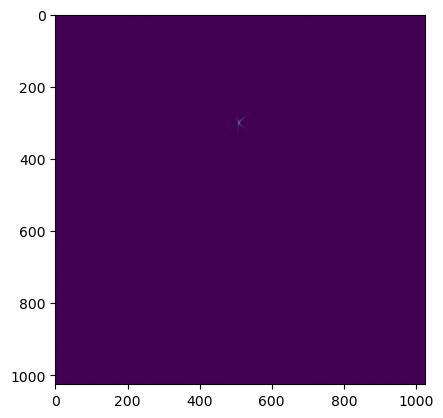

In [133]:
plt.imshow(reconstruction_fbp[6]) #696

3. Comparison with the performance of the 'iradon' function in skimage

20.00656485557556


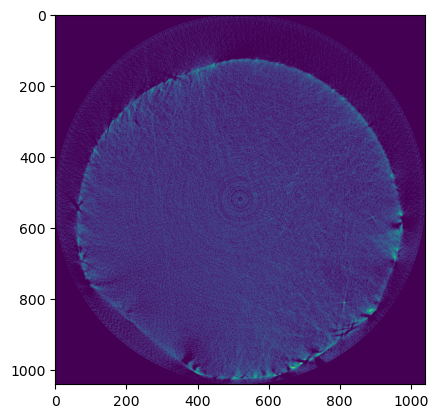

In [12]:
from skimage.transform import iradon
start = time.time()
skimage_output = iradon(np.moveaxis(im[400],0,1), theta=angles*180/np.pi, filter_name='ramp')
end = time.time()
print(end-start)
skimage_output[skimage_output < 0] = 0
plt.imshow(skimage_output)

In [14]:
3.86/0.0156

247.43589743589743